# H6C Simulation Tests

This notebook performs initial checks of the H6C simulations, which should be run with the top-level script `run_h6c_test_sets.sh`.

The test simulations consist of a few different cases, to test both frequency and temporal smoothness. For all cases, we investigate $N_{\rm side}=512$ and 1024, as well as linear and cubic spatial interpolation.



**Time Smoothness Sims**:

3 LST hours of simulation for two frequency channels. GSM and ptsrc.

**Frequency Smoothness Sims**:

A few minutes of LST for two bands of 150 channels each. GSM and EOR.

## Imports

In [1]:
from pyuvdata import FastUVH5Meta, UVData

In [2]:
from matplotlib import pyplot as plt

In [3]:
import numpy as np
from pathlib import Path
import h5py
import hera_pspec as hp
from uvtools.plot import waterfall
from scipy.signal.windows import blackmanharris
from hera_pspec import plot

In [4]:
# This is the cosmological parameter set in the input simulation
def astropyPlanck15_for_hera_pspec():
    H0 = 67.74
    h = H0/100.

    hp_cosmo = hp.conversions.Cosmo_Conversions(
        Om_L=0.6911, Om_b = .02230/h**2, Om_c = 0.1188/h**2, H0=H0
    )
    return hp_cosmo

cosmo = astropyPlanck15_for_hera_pspec()

## Frequency Smoothness

In [7]:
pth= Path("../outputs/ptsrc1024/nt17280-00001chunks-FULL-red/")

In [8]:
files = sorted(pth.glob("fch0*_*chunk00000.uvh5"))


In [9]:
len(files)

100

In [10]:
meta = FastUVH5Meta(files[0])

In [20]:
idx = 35
data = np.zeros(100, dtype=complex)

In [21]:
for i, fl in enumerate(files):
    with h5py.File(fl, 'r') as _fl:
        data[i] = _fl['Data']['visdata'][idx, 0, 0]

In [22]:
bh = blackmanharris(100)

In [23]:
power = np.abs(np.fft.fftshift(np.fft.fft(bh * data)))**2

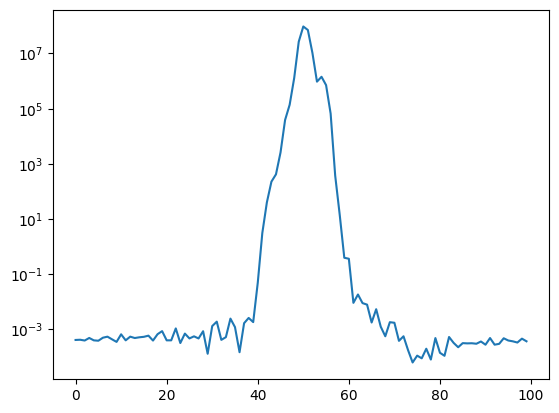

In [24]:
plt.plot(power)
plt.yscale('log')

In [25]:
meta.time_axis_faster_than_bls

False

In [26]:
#longtime = np.zeros(17280, dtype=complex)
with h5py.File(files[50], 'r') as fl:
    longtime = fl['Data']['visdata'][35::meta.Nbls, 0, 0]

In [28]:
lpower = np.abs(np.fft.fftshift(np.fft.fft(blackmanharris(17280) * longtime)))**2

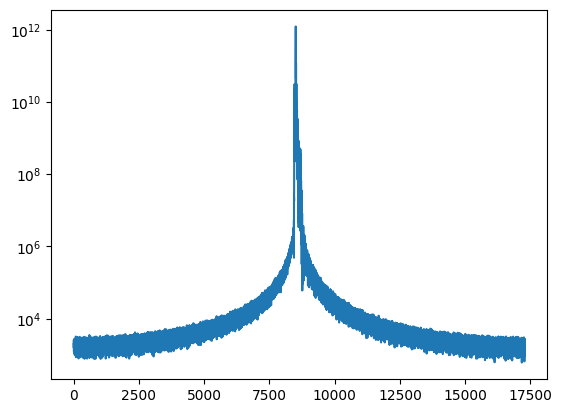

In [30]:
plt.plot(lpower)
plt.yscale('log')

In [ ]:
uvd = UVData.from_file(files, axis='freq', bls=[bl for bl in meta.antpairs if 0 in bl], run_check=False, lst_range=(0.1,0.11))

In [63]:
low_freqs = all_freq_uvds['gsm-512-spl1'].freq_array

In [64]:
# Load beam-dependent normalization data
omegas_data_path = '../vivaldi_solid_angle_and_reciever_power.h5'

with h5py.File(omegas_data_path, 'r') as h5f:
    Omega = h5f['directivity_integral'][()]
    Omegapp = h5f['directivity_square_integral'][()]
    f = h5f['frequencies_hz'][()]
    
mask = np.logical_and(f >= low_freqs.min(), f<= low_freqs.max())
assert np.sum(mask) == len(low_freqs)

# hera_pspec beam initiated from pre-computed integral data
hpsb = hp.pspecbeam.PSpecBeamFromArray(Omega[mask], Omegapp[mask], f[mask], cosmo=cosmo)

In [65]:
def get_ds(uvd):
    ps = hp.pstokes.construct_pstokes(uvd, uvd, pstokes='pI', run_check=False)
    ds = hp.PSpecData(dsets=[ps, ps], beam=hpsb)
    ds.Jy_to_mK()
    return ds

In [66]:
all_ds = {case: get_ds(uvd) for case, uvd in all_freq_uvds.items()}

No polarization convention in uvd1. Considering it to be "avg".
No polarization convention in uvd2. Considering it to be "avg".
Cannot convert dset 1 Jy -> mK because vis_units = mK
No polarization convention in uvd1. Considering it to be "avg".
No polarization convention in uvd2. Considering it to be "avg".
Cannot convert dset 1 Jy -> mK because vis_units = mK
No polarization convention in uvd1. Considering it to be "avg".
No polarization convention in uvd2. Considering it to be "avg".
Cannot convert dset 1 Jy -> mK because vis_units = mK
No polarization convention in uvd1. Considering it to be "avg".
No polarization convention in uvd2. Considering it to be "avg".
Cannot convert dset 1 Jy -> mK because vis_units = mK


In [67]:
def get_ps_cyl(uvd, ds, spw_ranges=None, blrange=(0, np.inf)):
    bllens = np.linalg.norm(uvd.uvw_array[:uvd.Nbls], axis=1)
    
    ant_pairs = [ant_pair for i, ant_pair in enumerate(uvd.get_antpairs()) if (ant_pair[0] != ant_pair[1] and blrange[0] < bllens[i] <= blrange[1])]
    if spw_ranges is None:
        spw_ranges = [(0, len(uvd.freq_array))]

    uvp = ds.pspec(
        ant_pairs, ant_pairs,
        dsets=(0,1),
        pols=('pI', 'pI'),
        input_data_weight='identity',
        norm='I',
        taper='blackman-harris',
        spw_ranges=spw_ranges,
        store_window=False,
        verbose=True,
        allow_fft=True,
        exact_norm=False
    )

    # time average for each (delay, baseline)
    uvp.average_spectra(time_avg=True, inplace=True)
    return uvp

In [68]:
all_ps_cyl = {case: get_ps_cyl(all_freq_uvds[case], all_ds[case]) for case in all_freq_uvds}

In [69]:
%%time
k_bin_widths = 0.02
k_bins = np.arange(0,1.4,k_bin_widths)

all_spherical_spectra = {key: hp.grouping.spherical_average(val, k_bins, k_bin_widths, run_check=False) for key, val in all_ps_cyl.items()}
# spherical_spectra_512 = {key: hp.grouping.spherical_average(val, k_bins, k_bin_widths, run_check=False) for key, val in ps_cyl_512.items()}
# spherical_spectra_1024 = {key: hp.grouping.spherical_average(val, k_bins, k_bin_widths, run_check=False) for key, val in ps_cyl_1024.items()}

CPU times: user 7.02 s, sys: 146 ms, total: 7.16 s
Wall time: 4.53 s


In [70]:
def make_high_delay_plot(ps, uvd, title):
    fig = plt.figure(figsize=(9,9))
    
    mask = ps.get_kparas(spw=0) > 0.4
    vals = []
    for i, key in enumerate(ps.get_all_keys()):
        val = np.mean(ps.get_data(key).flatten()[mask].real)
        vals.append(val)

    uvw = uvd.uvw_array[:uvd.Nbls].copy()
    
    flip = np.array([a > b for a, b in zip(uvd.ant_1_array[:uvd.Nbls], uvd.ant_2_array[:uvd.Nbls])])
    uvw[flip] *= -1
    
    plt.scatter(uvw[:, 0], uvw[:, 1], c=np.log10(vals))
    if title:
        plt.title(title)
    return fig

In [71]:
def make_all_freq_plots(case):
    #fig1 = make_high_delay_plot(all_ps_cyl[case], all_freq_uvds[case], title=case)
    fig3 = plot.delay_wedge(all_ps_cyl[case], spw=0, pol=('pI', 'pI'), rotate=True, horizon_lines=True, colorbar=True, vmin=8, vmax=20);
    plt.title(case)
    return fig3

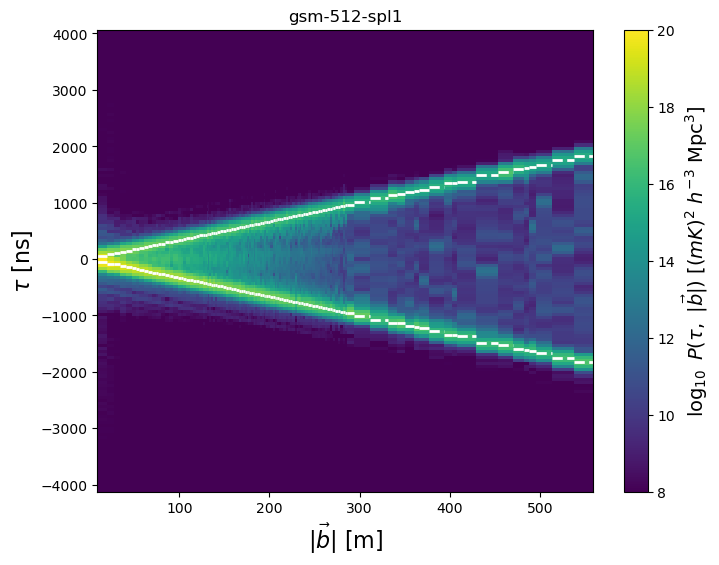

In [72]:
make_all_freq_plots('gsm-512-spl1');

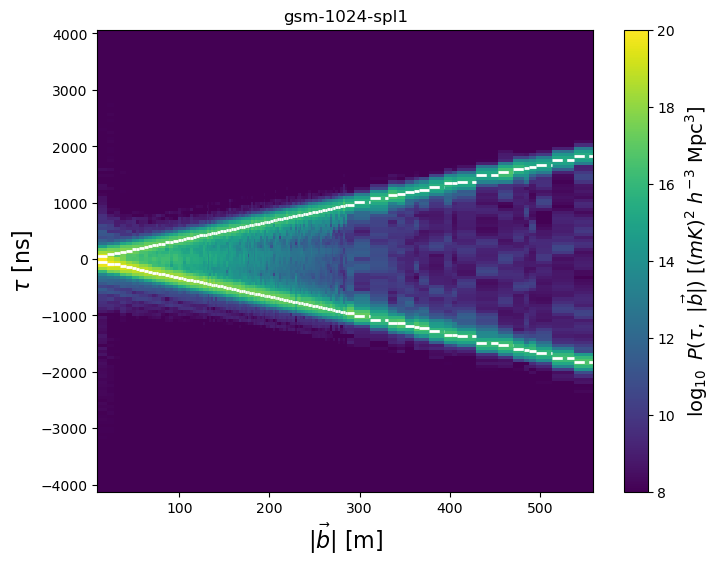

In [73]:
make_all_freq_plots('gsm-1024-spl1');

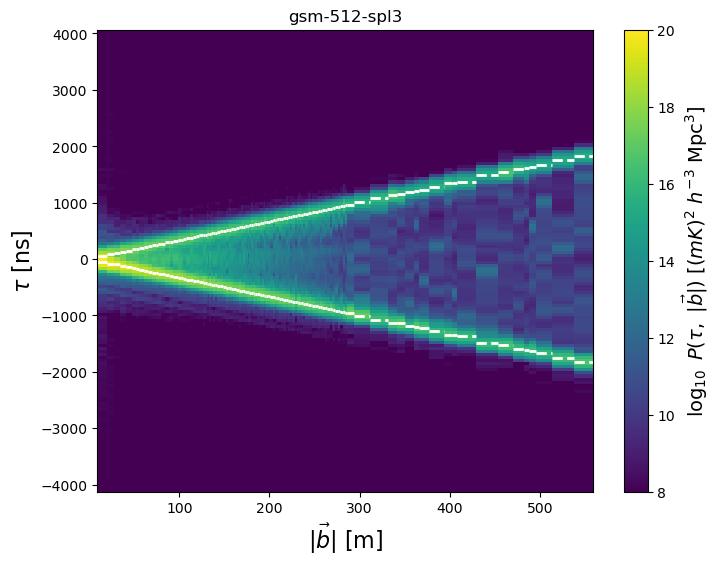

In [76]:
make_all_freq_plots('gsm-512-spl3');

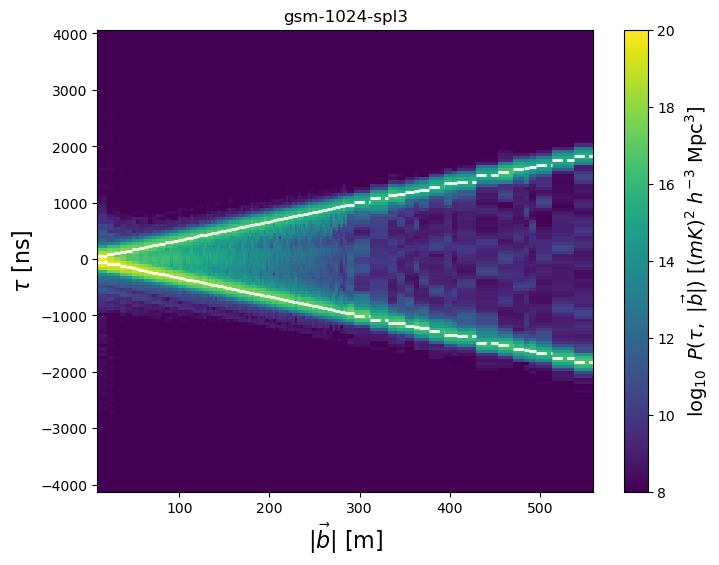

In [74]:
make_all_freq_plots('gsm-1024-spl3');

## Time Smoothness


In [77]:
try:
    del all_ps_cyl
except:
    pass

In [78]:
time_cases = {
    'gsm-512-spl1': Path("../outputs/gsm_nside512/order1/nt17280-00024chunks-FULL-red/"),
    'gsm-1024-spl1': Path("../outputs/gsm_nside1024/order1/nt17280-00024chunks-FULL-red/"),
    'ptsrc-512-spl1': Path("../outputs/ptsrc512/order1/nt17280-00024chunks-FULL-red/"),
    'ptsrc-1024-spl1': Path("../outputs/ptsrc512/order1/nt17280-00024chunks-FULL-red/"),
    'gsm-512-spl3': Path("../outputs/gsm_nside512/order3/nt17280-00024chunks-FULL-red/"),
    'gsm-1024-spl3': Path("../outputs/gsm_nside1024/order3/nt17280-00024chunks-FULL-red/"),
    'ptsrc-512-spl3': Path("../outputs/ptsrc512/order3/nt17280-00024chunks-FULL-red/"),
    'ptsrc-1024-spl3': Path("../outputs/ptsrc512/order3/nt17280-00024chunks-FULL-red/"),
}
    
time_files_low = {
    case: sorted(d.glob("*fch0001*.uvh5")) for case, d in time_cases.items()
}
time_files_high = {
    case: sorted(d.glob("*fch1500*.uvh5")) for case, d in time_cases.items()
}


In [79]:
meta = FastUVH5Meta(time_files_low['gsm-512-spl1'][0])

In [80]:
def perform_frt(uvd, time_mask=None):
    d = uvd.data_array.reshape((uvd.Ntimes, uvd.Nbls, 1, uvd.Npols))
    if time_mask is not None:
        d = d[time_mask]
        
    window = blackmanharris(d.shape[0])
    out = np.abs(np.fft.fftshift(np.fft.fft(d.T*window, axis=-1), axes=-1).T)**2
    
    frs = np.fft.fftshift(np.fft.fftfreq(d.shape[0], d=(uvd.time_array[uvd.Nbls] - uvd.time_array[0])*86400))
    return frs, out

In [81]:
from pyuvdata.utils.pol import polnum2str

In [86]:
def plot_frt(uvd, frs, data_fft, title=None):
    fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, gridspec_kw={"hspace": 0.01, 'wspace': 0.01}, constrained_layout=True, figsize=(9,9))

    for bl in range(uvd.Nbls):
        ax[0,0].plot(frs, data_fft.T[0,0,bl], color='k' if bl<320 else 'r', alpha=0.3)
        ax[0,1].plot(frs, data_fft.T[1,0,bl], color='k' if bl<320 else 'r', alpha=0.3)
        ax[1,0].plot(frs, data_fft.T[2,0,bl], color='k' if bl<320 else 'r', alpha=0.3)
        ax[1,1].plot(frs, data_fft.T[3,0,bl], color='k' if bl<320 else 'r', alpha=0.3)

    ax[0,0].set_title(polnum2str(uvd.polarization_array[0]))
    ax[0,1].set_title(polnum2str(uvd.polarization_array[1]))
    ax[1, 0].set_title(polnum2str(uvd.polarization_array[2]))
    ax[1, 1].set_title(polnum2str(uvd.polarization_array[3]))

    ax[1, 0].set_xlabel("Fringe-Rate [Hz]")
    ax[1,1].set_xlabel("Fringe-Rate [Hz]")


    ax[0,0].set_yscale('log')
    ax[0,0].set_ylabel(r"$|\tilde{V}|^2$")
    ax[1,0].set_ylabel(r"$|\tilde{V}|^2$")
    if title:
        fig.suptitle(title)
        
    return fig

In [83]:
def plot_high_fr_power(frs, data_fft, uvd, polidx=0, title=None):
    dmask = data_fft[np.abs(frs)>0.025, :, 0, polidx]
    dmax = np.max(dmask, axis=0)
    
    uvw = uvd.uvw_array[:uvd.Nbls].copy()
    
    flip = np.array([a > b for a, b in zip(uvd.ant_1_array[:uvd.Nbls], uvd.ant_2_array[:uvd.Nbls])])
    uvw[flip] *= -1
    
    fig = plt.figure(figsize=(10,10))
    plt.scatter(uvw[:, 0], uvw[:, 1], c=dmax.flatten())
    cax = plt.colorbar()
    cax.set_label("Highest Power outside 25 mHz")
    
    plt.xlabel("u [m]")
    plt.ylabel("v [m]")
    if title:
        plt.title(title)
        
    return np.argmax(dmax), np.argmax(dmax[:320]), fig

In [84]:
all_uvds = {case: UVData.from_file(time_files_low[case], axis='blt', bls=[bl for bl in meta.antpairs if 0 in bl], run_check=False) for case in time_files_low}

antenna_diameters are not set or are being overwritten. antenna_diameters are set using values from known telescopes for HERA.
antenna_diameters are not set or are being overwritten. antenna_diameters are set using values from known telescopes for HERA.
antenna_diameters are not set or are being overwritten. antenna_diameters are set using values from known telescopes for HERA.
antenna_diameters are not set or are being overwritten. antenna_diameters are set using values from known telescopes for HERA.
antenna_diameters are not set or are being overwritten. antenna_diameters are set using values from known telescopes for HERA.
antenna_diameters are not set or are being overwritten. antenna_diameters are set using values from known telescopes for HERA.
antenna_diameters are not set or are being overwritten. antenna_diameters are set using values from known telescopes for HERA.
antenna_diameters are not set or are being overwritten. antenna_diameters are set using values from known teles

In [97]:
def make_all_plots_for_a_case(case):
    uvd = all_uvds[case]
    title = case
    
    frs, data_fft = perform_frt(uvd)
    fig1 = plot_frt(uvd, frs, data_fft, title=title)
    worst_bl, worst_core_bl, fig2 = plot_high_fr_power(frs, data_fft, uvd, polidx=3, title=title)
    
    fig3, ax = plt.subplots(1,1)
    plt.plot(uvd.lst_array[::uvd.Nbls]*12/np.pi, uvd.data_array.reshape((uvd.Ntimes, uvd.Nbls, uvd.Nfreqs, uvd.Npols))[:, worst_bl,  0, 3].real, label='outrigger', color='r')
    plt.plot(uvd.lst_array[::uvd.Nbls]*12/np.pi, uvd.data_array.reshape((uvd.Ntimes, uvd.Nbls, uvd.Nfreqs, uvd.Npols))[:, worst_core_bl,  0, 3].real, label='core', color='k')

    plt.xlabel("LST [hr]")
    plt.ylabel("Visibility [real]")
    plt.title(f"Visibility for worst baseline ({worst_bl}, {worst_core_bl})")
    plt.legend()
    
    return fig1, fig2, fig3

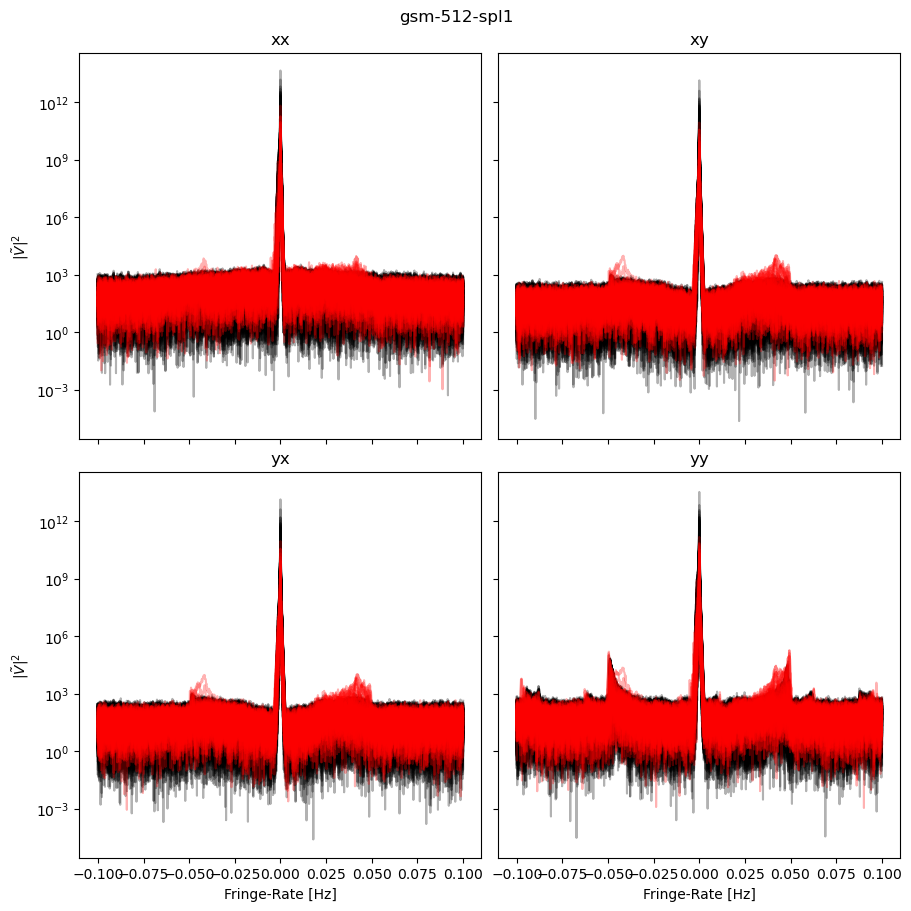

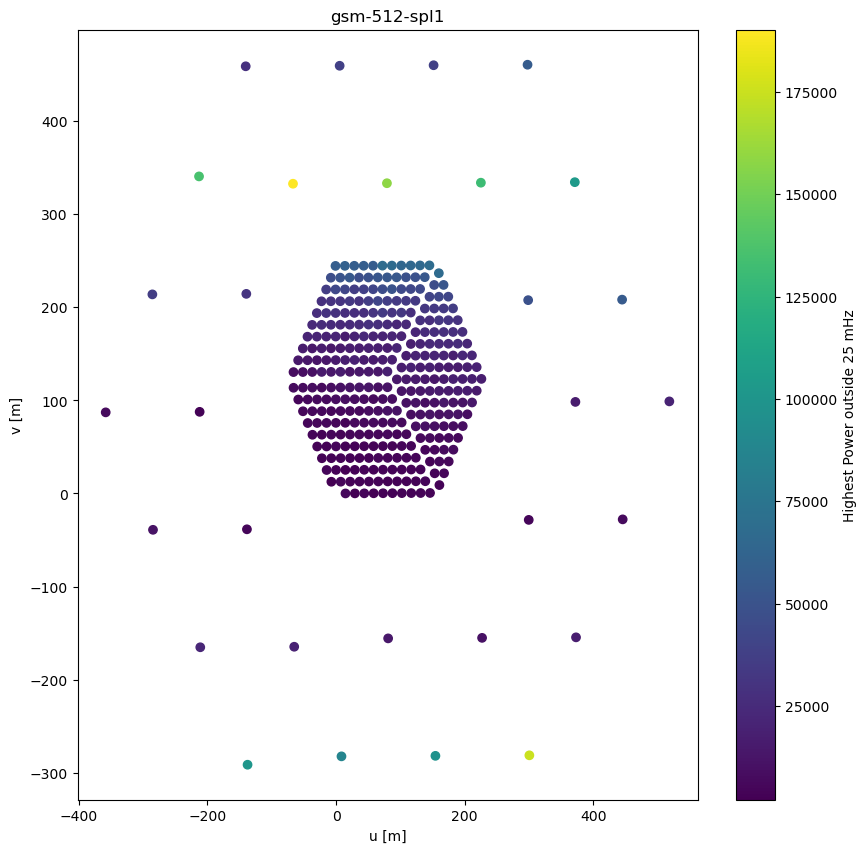

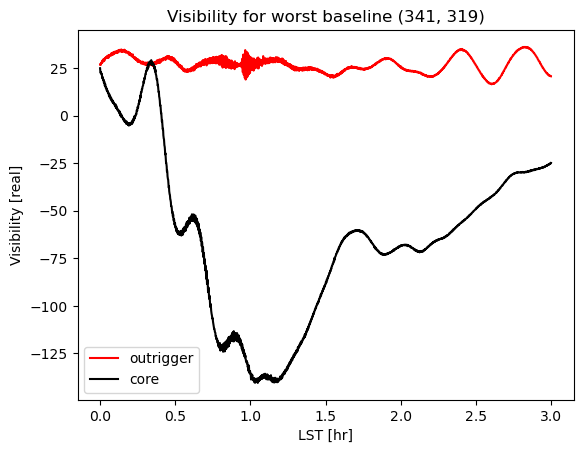

In [98]:
make_all_plots_for_a_case("gsm-512-spl1");

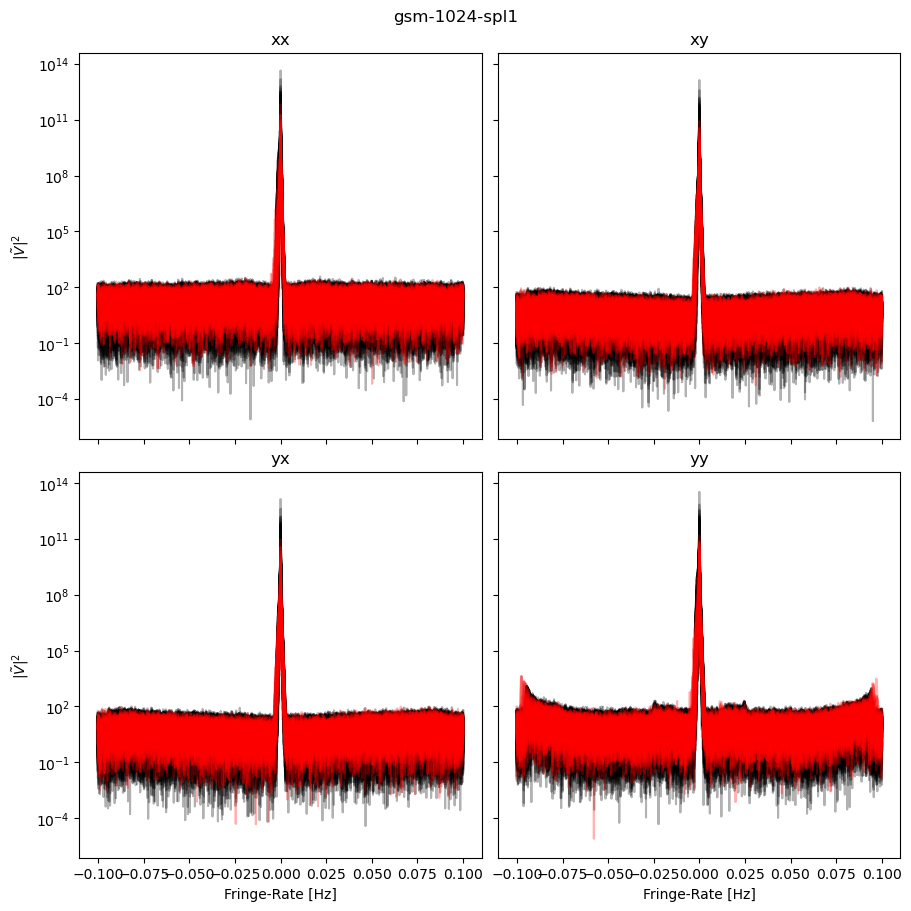

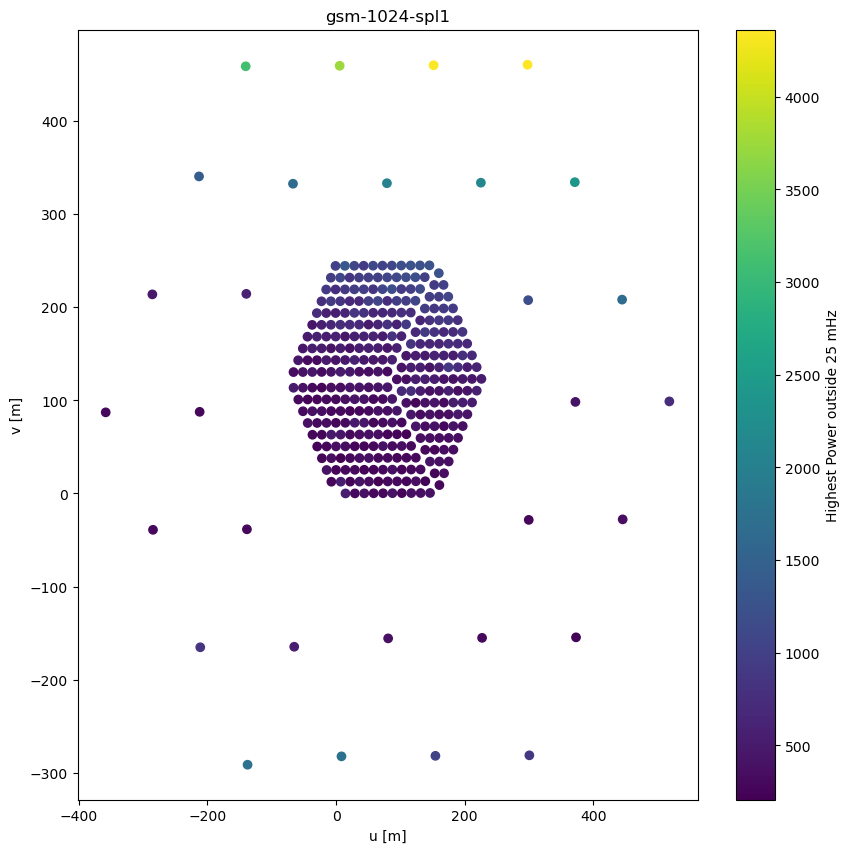

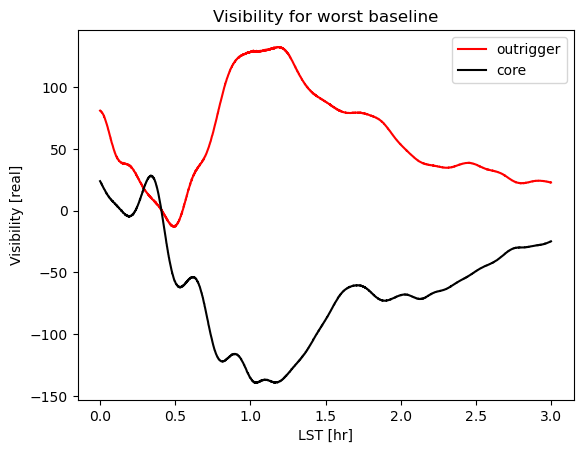

In [92]:
make_all_plots_for_a_case("gsm-1024-spl1");

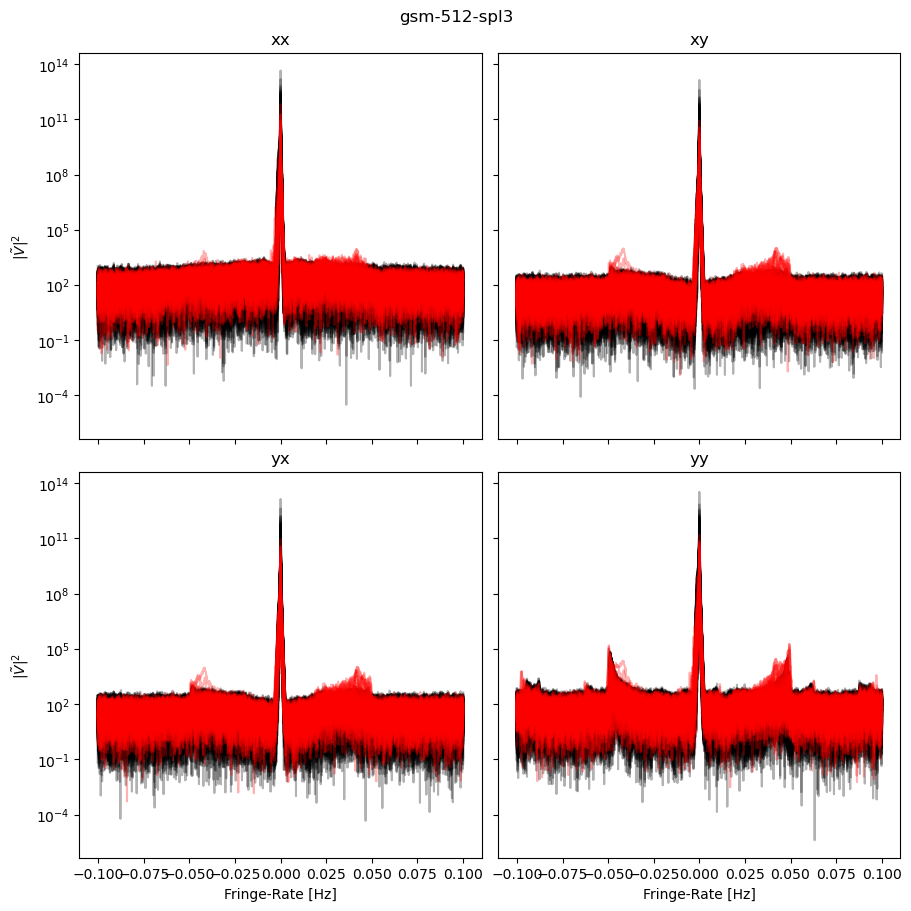

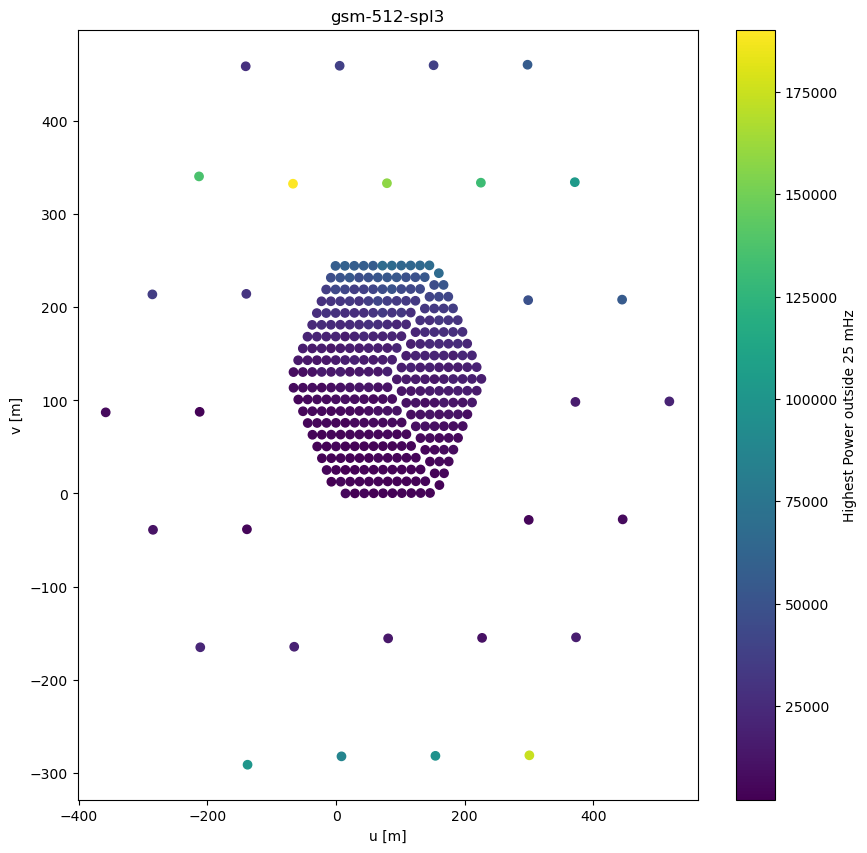

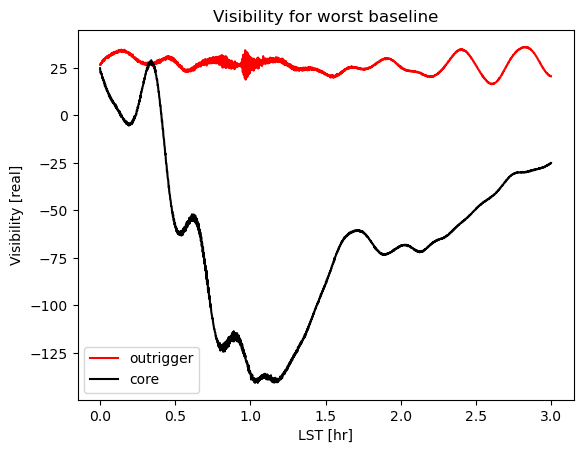

In [93]:
make_all_plots_for_a_case("gsm-512-spl3");

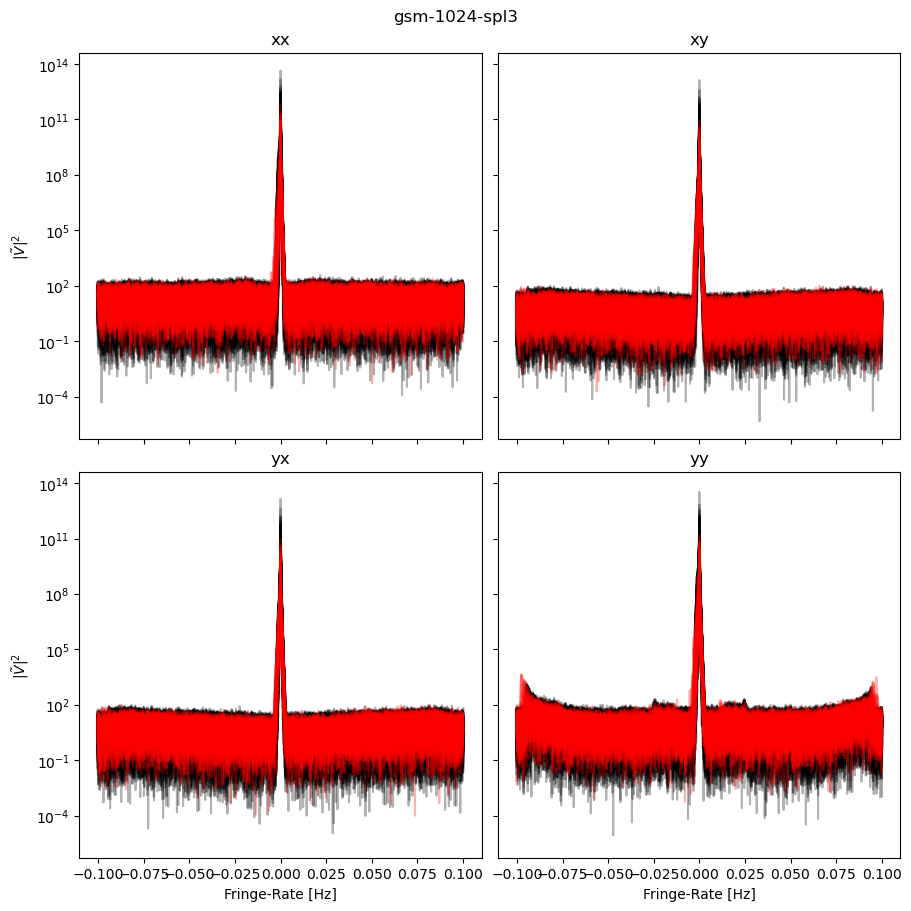

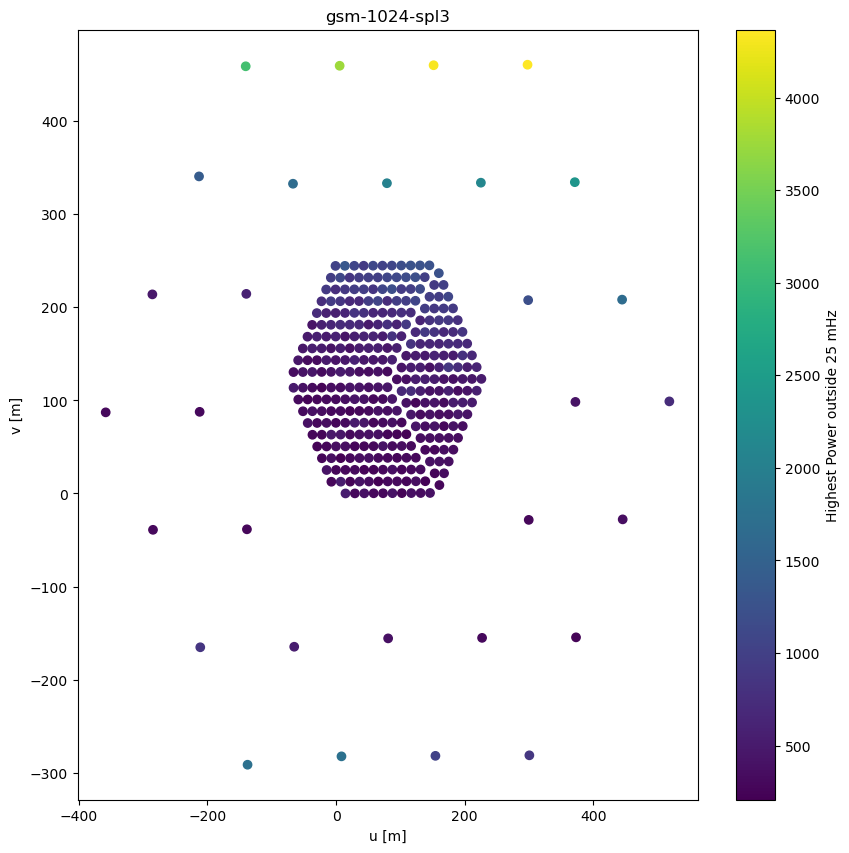

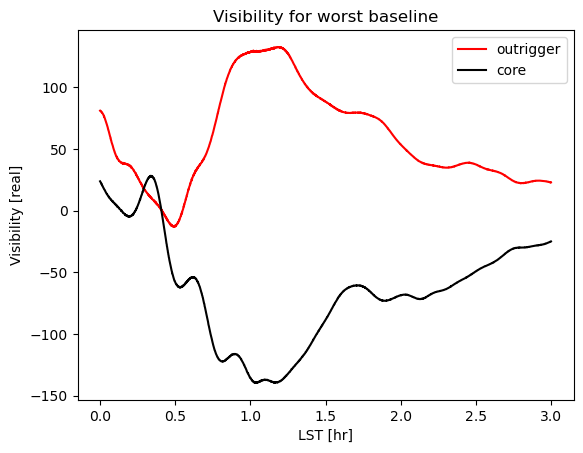

In [94]:
make_all_plots_for_a_case("gsm-1024-spl3");

### Does using the third-order spline make a difference?

In [99]:
_u = all_uvds['gsm-1024-spl1']
dshape = (_u.Ntimes, _u.Nbls, _u.Nfreqs, _u.Npols)

In [95]:
np.abs(all_uvds['gsm-512-spl1'].data_array - all_uvds['gsm-512-spl3'].data_array  ).max()

4.660450881637522

Text(0, 0.5, 'Visibility (Real)')

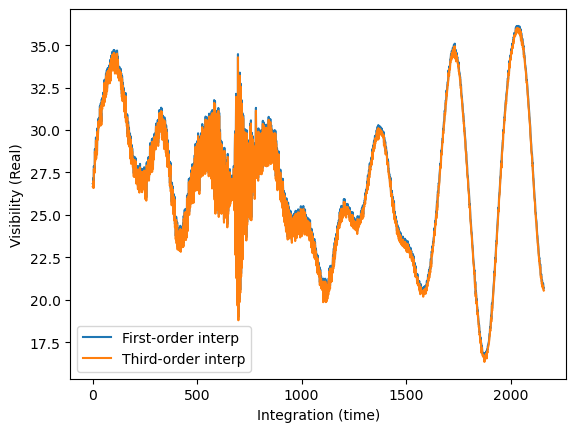

In [103]:
plt.plot(all_uvds['gsm-512-spl1'].data_array.reshape(dshape)[:, 341, 0, 3].real, label='First-order interp')
plt.plot(all_uvds['gsm-512-spl3'].data_array.reshape(dshape)[:, 341, 0, 3].real, label='Third-order interp')
plt.legend()
plt.xlabel("Integration (time)")
plt.ylabel("Visibility (Real)")